In [1]:
import pandas as pd
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from bayes_opt import BayesianOptimization
import shap
import scipy.stats as stats
import pyreadr
import numpy as np
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

C:\Users\farza\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\farza\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\farza\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\farza\anaconda3\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\farza\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\farza\anaconda3\lib\site-packages\dask\

## Importing the data and preparing the EOT and follow-up weight loss percent

In [2]:
df_topex = pd.read_csv('Smart_EBests (1).dat', header=None,   delim_whitespace=True)
df_engagement = pd.read_csv('engagement.csv')
df_topex.columns = ['Subject_ID',
                    'loc1_Cal','loc2_Cal','sca1_Cal','sca2_Cal', 
                    'loc1_Fat','loc2_Fat','sca1_Fat','sca2_Fat',
                    'loc1_Fair','loc2_Fair','sca_Fair',
                    'loc1_Light','loc2_Light','sca_Light',
                    'loc1_Very','loc2_Very','sca_Very',
                    'loc1_Step','loc2_Step','sca_Step']

df_features_smart = pd.read_csv('maintenance_analatic_data.csv')
df_features_smart['weightloss_3mon'] = ((df_features_smart['baseline_weight']-df_features_smart['3mo_weight'])/df_features_smart['baseline_weight']) * 100
df_features_smart['weightloss_6mon'] = ((df_features_smart['baseline_weight']-df_features_smart['6mo_weight'])/df_features_smart['baseline_weight']) * 100
df_features_smart['weightloss_12mon'] = ((df_features_smart['baseline_weight']-df_features_smart['12mo_weight'])/df_features_smart['baseline_weight']) * 100

## Weight loss scatter plot based on the amount of weight loss percent EOT and 12 week follow-up

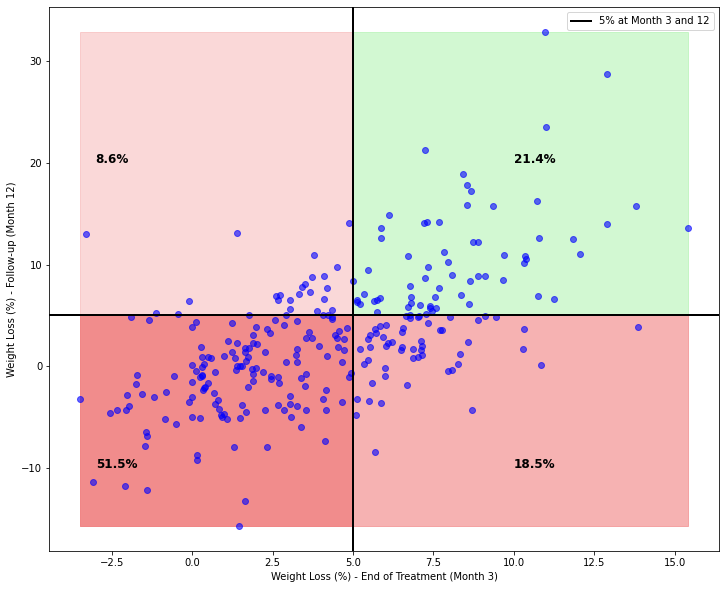

In [3]:
weight_loss_3mon = df_features_smart['weightloss_3mon']
weight_loss_12mon = df_features_smart['weightloss_12mon']

# Define threshold for 5% weight loss at Month 3 and Month 12
threshold_3mon = 5  # Vertical line
threshold_12mon = 5  # Horizontal line

# Create scatter plot
plt.figure(figsize=(12, 10))


# Highlight quadrants
plt.axvline(threshold_3mon, color='black', linewidth=2, label="5% at Month 3 and 12")
plt.axhline(threshold_12mon, color='black', linewidth=2)

# Shade the top-right quadrant
plt.fill_betweenx(y=[min(weight_loss_12mon), threshold_12mon], x1=min(weight_loss_3mon), x2=threshold_3mon, color='lightcoral', alpha=0.9)  # Bottom-left
plt.fill_betweenx(y=[min(weight_loss_12mon), threshold_12mon], x1=threshold_3mon, x2=max(weight_loss_3mon), color='lightcoral', alpha=0.6)  # Bottom-right
plt.fill_betweenx(y=[threshold_12mon, max(weight_loss_12mon)], x1=min(weight_loss_3mon), x2=threshold_3mon, color='lightcoral', alpha=0.3)  # Top-left
plt.fill_betweenx(y=[threshold_12mon, max(weight_loss_12mon)], x1=threshold_3mon, x2=max(weight_loss_3mon), color='lightgreen', alpha=0.4)  # Top-right
plt.scatter(weight_loss_3mon, weight_loss_12mon, alpha=0.6, color="blue")
# Label quadrants with approximate placeholders
plt.text(-3, 20, "8.6%", fontsize=12, weight='bold')
plt.text(-3, -10, "51.5%", fontsize=12, weight='bold')
plt.text(10, -10, "18.5%", fontsize=12, weight='bold')
plt.text(10, 20, "21.4%", fontsize=12, weight='bold')

# Labels and title
plt.xlabel("Weight Loss (%) - End of Treatment (Month 3)")
plt.ylabel("Weight Loss (%) - Follow-up (Month 12)")
#plt.title("Weight Loss Maintenance Distribution")

# Show plot
plt.legend()
#plt.savefig('weightdistribution.png', dpi=500)
plt.show()

## Weight maintenance outcome

In [4]:
def bonusOutcome(row):
    #val = row['slope_intervention']
    # if (row['slope_intervention'] > 0 and row['follow_up'] >= 0.85*row['intervention'] and  row['follow_up'] >= row['baseline']):
    #     val = 'Maintainer'
        
    # if (row['mean_intervention'] >= row['mean_bl'] and  row['mean_follow_up'] >= 0.9*row['mean_intervention']):
    #     val = 'Maintainer'        
    if (row['weightloss_3mon'] >= 5 and  row['weightloss_12mon'] >= 5):
        val = 1   

    # if (row['slope_follow_up'] >= 0 ):
    #     val = 'Maintainer'        
        
    else:
        val = 0
    return val

## Preprocessing the data and standardization

In [5]:
final_don_data = df_topex[['Subject_ID',
                    'loc1_Cal','loc2_Cal','sca2_Cal', 'sca1_Cal',
                    'loc1_Fat','loc2_Fat','sca2_Fat','sca1_Fat',
                    'loc1_Very','loc2_Very','sca_Very',
                   ]]
df_filled = final_don_data.fillna(0)
df_features_smart['Label'] = df_features_smart.apply(bonusOutcome, axis=1)

result = pd.merge(df_features_smart, df_filled, how='left', left_on='ID', right_on='Subject_ID')
result_final = pd.merge(result, df_engagement, how='left', left_on='ID', right_on='participantNumber')
#result_final.to_csv('result1.csv')

ready_ml_data = pd.read_csv('result1.csv')
for column in ready_ml_data.columns:
    ready_ml_data[column] = pd.to_numeric(ready_ml_data[column], errors='coerce')
ready_ml_data = ready_ml_data.fillna(0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
continuous_columns = ['delta_84', 'max', 'min', '75percentile', 'slope', 'intercept',
                     'loc1_Cal','loc2_Cal','sca2_Cal', 'sca1_Cal',
                    'loc1_Fat','loc2_Fat','sca2_Fat','sca1_Fat',
                    'loc1_Very','loc2_Very','sca_Very',                  
                    'heightInInches', 'web_age',  'se_exercise_score',
                    'se_diet_score',  'baseline_weight', 
                    'total_duration_seconds', 'session_count',
                    'custom_food']

# Standardize the continuous columns
ready_ml_data[continuous_columns] = scaler.fit_transform(ready_ml_data[continuous_columns])

X, y = ready_ml_data.drop(columns=['Label']), ready_ml_data['Label']
X = X.reset_index(drop = True)

## Training the deep neural net encoder 

In [6]:
X_CV = X
y_CV = y

# array with possible alphas to test
# alphas = np.logspace(-8, -5, num=7)
alphas = [1.00e-05]#[2e-5] # best perfoming one from previous line 
rand_state = 3 #3

# set number of folds and initialise sklearn KFold
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=rand_state)

val_best_nn = 0

for alpha in alphas:

    
    # initialize Neural Network
    nn = MLPClassifier(hidden_layer_sizes=(200,100,50,5), max_iter=1000, alpha=alpha, solver='sgd',
                       verbose=False, random_state=rand_state, activation='relu', batch_size=16)

    # Start with k-fold cross validation
    class_scores_train = []
    class_scores_val = []
    
    for train_index, val_index in kf.split(X_CV, y_CV):

        # set up Neural Network
        nn.fit(X_CV.iloc[train_index], y_CV.iloc[train_index].values.ravel())  # ravel flattens the array from (X, 1) to (X, )

        # predict y_train, y_val
        predictions_train = nn.predict(X_CV.iloc[train_index])
        predictions_val = nn.predict(X_CV.iloc[val_index])

        # append accuracy to appropriate list
        class_scores_train.append(accuracy_score(y_CV.iloc[train_index],predictions_train))
        class_scores_val.append(accuracy_score(y_CV.iloc[val_index],predictions_val))
    
    if np.mean(class_scores_val) > val_best_nn:
        val_best_nn = np.mean(class_scores_val)
        best_nn = nn
    
    print('alpha: {:.2e} | mean(train_acc): {:.2f} | mean(val_acc): {:.2f}'.
          format(alpha,
                 round(np.mean(class_scores_train),4),
                 round(np.mean(class_scores_val),4)))

alpha: 1.00e-05 | mean(train_acc): 1.00 | mean(val_acc): 0.81


## Getting the latent representations from the final layer

In [7]:
# Rebuild forward loop to get output of last hidden layer
out_layer = np.maximum(np.matmul(X.values, best_nn.coefs_[0]) + best_nn.intercepts_[0], 0, out=np.matmul(X.values, best_nn.coefs_[0]) + best_nn.intercepts_[0])

# Forward pass through layers up until the 2 last. Last is for classification, 2nd-to-last we do not want the activation
no_layers = len(best_nn.intercepts_)-1
for i in range(1,no_layers-1): 
    out_layer = np.maximum(np.matmul(out_layer, best_nn.coefs_[i]) + best_nn.intercepts_[i], 0, out=np.matmul(out_layer, best_nn.coefs_[i]) + best_nn.intercepts_[i])

out_layer_3outputs = np.matmul(out_layer, best_nn.coefs_[no_layers-1]) + best_nn.intercepts_[no_layers-1]

df_nnout = pd.DataFrame(out_layer_3outputs, index=X.index, columns=['Dim_1', 'Dim_2', 'Dim_3',
                        'Dim_4', 'Dim_5'])
                        #, 'Dim_6','Dim_7', 'Dim_8', 'Dim_9','Dim_10']) 
                        #'Dim_11', 'Dim_12','Dim_13', 'Dim_14', 'Dim_15',
                        #'Dim_16', 'Dim_17','Dim_18', 'Dim_19', 'Dim_20',
                        #'Dim_21', 'Dim_22','Dim_23', 'Dim_24', 'Dim_25'])


## UMAP training and K-mean clustering and visualization of the separable maintainers and non-maintainers clusters

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


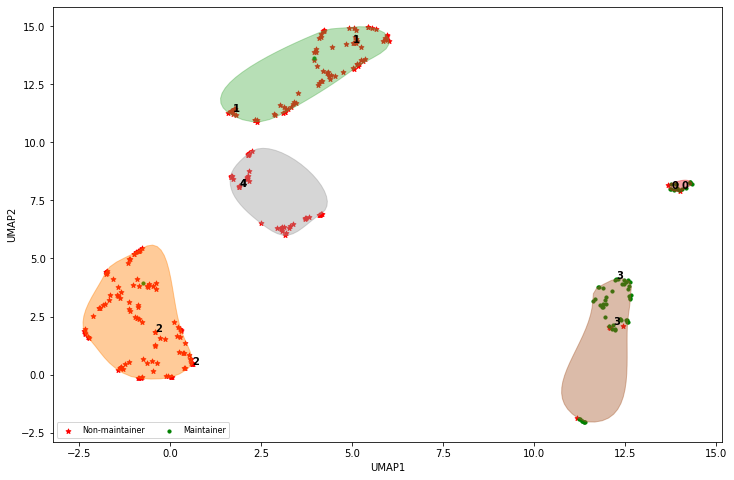

In [9]:
# # Plot the 2D t-SNE plot
import seaborn as sns
# sns.set_palette('Set1')
# sns.scatterplot(x=df_resTSNE_2D.tsne_Dim1, y=df_resTSNE_2D.tsne_Dim2, data=dataframe_final, hue='obj_overeating_flag',
#                edgecolor='k', s=10).set_title('Org - t-SNE plot with MLP preprocessing')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# res_tsne = sklearnTSNE(n_components=3, perplexity=20, random_state=42).fit_transform(df_nnout)
# df_resTSNE = pd.DataFrame(res_tsne, columns=['tsne_Dim1', 'tsne_Dim2', 'tsne_Dim3'], index=dataframe_final.index)


# Perform UMAP 3D
res_umap3d_columns = ['UMAP_3_1', 'UMAP_3_2'] 
res_df_nnout_umap3d = pd.DataFrame(index=X.index, columns=res_umap3d_columns)

from umap import UMAP
from sklearn.manifold import TSNE

scl = StandardScaler()

df_nnout = pd.DataFrame(scl.fit_transform(df_nnout))
min_dist = 0.015

# [0.0, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035,
#                    0.04,0.045,0.05,0.055,0.06,0.065, 0.07,0.075,0.08,0.085,0.09,0.1
#                  ]  # Feel free to adjust these values
n_neighbors = 5

        
model_umap3d= UMAP(n_neighbors=n_neighbors,
         min_dist=min_dist,
         n_components=2,
         metric='euclidean', random_state=20)
#        model_umap3d = TSNE(n_components=3, verbose=1, perplexity=50, n_iter=300)
# Fit model
res_df_nnout_umap3d[['UMAP_3_1', 'UMAP_3_2']] = model_umap3d.fit_transform(df_nnout)

if True:
    min_dist_values = [0.010]#[0, 0.001, 0.01, 0.1, 0.5]
    n_neighbors_values = [5]#[2, 3, 4, 5, 6, 7]

    for min_dist in min_dist_values:
        for n_neighbors in n_neighbors_values:
   

            from umap import UMAP
            model_umap2d= UMAP(n_neighbors=n_neighbors,
                         min_dist=min_dist,
                         n_components=2,
                         metric= 'euclidean', random_state=20)
        
            # Fit model
            res_umap2d_columns = ['UMAP_3_1', 'UMAP_3_2'] 
            umap_2d_shap_rep = None
            umap_2d_shap_rep = pd.DataFrame(model_umap2d.fit_transform(df_nnout))
            umap_2d_shap_rep.columns = ['UMAP_3_1', 'UMAP_3_2']
            
            import matplotlib.pyplot as plt
            y_gt = pd.DataFrame(y)
            y_gt.columns = ['y_gt']
        #    predictions = pd.DataFrame(predictions)
        #    predictions.columns = ['predictions']
        #    predictions_gt = pd.concat([predictions,y_gt], axis =1)
            
            maintainer_y_gt1 = y_gt.loc[(y_gt['y_gt'] == 1)]
            non_maintainer_y_gt0 = y_gt.loc[(y_gt['y_gt'] == 0)]    
        #    predictions_y_gt0_FP = predictions_gt.loc[(predictions_gt['y_gt'] == 0) & (predictions_gt['predictions'] == 1)]
        #    predictions_y_gt1_TP = predictions_gt.loc[(predictions_gt['y_gt'] == 1) & (predictions_gt['predictions'] == 1)]
        #    predictions_y_gt1_TN = predictions_gt.loc[(predictions_gt['y_gt'] == 0) & (predictions_gt['predictions'] == 0)]
            fig = plt.figure(figsize=(12, 8))
            axarr = fig.add_subplot(1, 1, 1)
            umap_2d_shap_rep_gt = pd.concat([umap_2d_shap_rep,y_gt], axis =1)
            umap_2d_shap_rep_gt_maintainer = umap_2d_shap_rep_gt.loc[(umap_2d_shap_rep_gt['y_gt'] == 1)]
            umap_2d_shap_rep_gt_non_maintainer = umap_2d_shap_rep_gt.loc[(umap_2d_shap_rep_gt['y_gt'] == 0)]
        #    umap_2d_shap_rep_gt_TN = umap_2d_shap_rep_gt.loc[(umap_2d_shap_rep_gt['y_gt'] == 0) & (umap_2d_shap_rep_gt['predictions'] == 0)]
         #   umap_2d_shap_rep_gt_TP = umap_2d_shap_rep_gt.loc[(umap_2d_shap_rep_gt['y_gt'] == 1) & (umap_2d_shap_rep_gt['predictions'] == 1)]
            
            from sklearn.cluster import KMeans
            clustering = KMeans(init="random", n_clusters=5, n_init=10, max_iter=300, random_state=10)
            umap_2d_shap_rep_clustering = pd.concat([umap_2d_shap_rep_gt_maintainer, umap_2d_shap_rep_gt_non_maintainer], axis = 0)
            clustering.fit(umap_2d_shap_rep[['UMAP_3_1', 'UMAP_3_2']])
            kmeans_kwargs = {
            "init": "random",
            "n_init": 10,
            "max_iter": 300,
            "random_state": 42,
            }   
            clust_label = pd.DataFrame(clustering.labels_, columns = ["clus_label"])
            from scipy.spatial import ConvexHull
            from scipy import interpolate
            from matplotlib.colors import rgb2hex
            from matplotlib.cm import get_cmap
            n = clust_label['clus_label'].unique().shape[0]
            colormap = get_cmap('Set1')
            colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]
            
            #clust_label_color = clust_label.replace([0, 1, 2, 3, 4, 5], colors)
        #    cluster_label_FP = clust_label.iloc[:77]
        #    cluster_label_FP.index = umap_2d_shap_rep_clustering.iloc[:77].index
        
        #    cluster_label_TN = clust_label.iloc[77:]
        #    cluster_label_TN.index = umap_2d_shap_rep_clustering.iloc[77:].index
        
            
            l1 = axarr.scatter(x=umap_2d_shap_rep_gt_non_maintainer['UMAP_3_1'], y=umap_2d_shap_rep_gt_non_maintainer['UMAP_3_2'], c = 'r', marker='*', alpha=1, s=25)
            l2 = axarr.scatter(x=umap_2d_shap_rep_gt_maintainer['UMAP_3_1'], y=umap_2d_shap_rep_gt_maintainer['UMAP_3_2'], c = 'g', marker='o', alpha=1, s=10)
            res_df_nnout_umap3d_clustered = pd.concat([umap_2d_shap_rep, clust_label], axis = 1)
        #    res_df_nnout_umap3d_clustered = pd.concat([pd.concat([umap_2d_shap_rep_gt_FN.reset_index(drop=True), umap_2d_shap_rep_gt_TP.reset_index(drop=True)],axis=0).reset_index(drop = True), clust_label], axis = 1)                  
            for i in clust_label['clus_label'].unique():
                # get the convex hull
                points = res_df_nnout_umap3d_clustered[res_df_nnout_umap3d_clustered.clus_label == i][['UMAP_3_1', 'UMAP_3_2']].values
                hull = ConvexHull(points)
                x_hull = np.append(points[hull.vertices,0],
                                   points[hull.vertices,0][0])
                y_hull = np.append(points[hull.vertices,1],
                                   points[hull.vertices,1][0])
                
                # interpolate
                dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
                dist_along = np.concatenate(([0], dist.cumsum()))
                spline, u = interpolate.splprep([x_hull, y_hull], 
                                                u=dist_along, s=0, per=1)
                interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
                interp_x, interp_y = interpolate.splev(interp_d, spline)
                # plot shape
                axarr.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.4)
            
                tmp = res_df_nnout_umap3d_clustered.loc[res_df_nnout_umap3d_clustered['clus_label']==i].sample(2)
                
                #add label to some random points per group
                for _,row in tmp.iterrows():
                    axarr.annotate(i, (row['UMAP_3_1'], row['UMAP_3_2']), size=10, weight='bold', color='k')
                #plt.figure(figsize=(12, 10))    
                #axarr.set_title('SHAP Dimensionality Reduction', fontsize=15)
                axarr.set_xlabel('UMAP1', fontsize=10)
                axarr.set_ylabel('UMAP2', fontsize=10)
                
                plt.legend((l1, l2),
                   ('Non-maintainer', 'Maintainer'),
                   scatterpoints=1,
                   loc='lower left',
                   ncol=3,
                   fontsize=8)
                #plt.show()
                #plt.savefig('C://Users//farza//Downloads//SMART maintenance//UMAPfigs//' + 'umap' + str(min_dist)+ ' '+ str(n_neighbors)+'.png', dpi = 200)
                plt.savefig('2_drepresentation.png', dpi = 500)